In [1]:
import pandas as pd
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing

from sklearn.utils import shuffle
# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import LeaveOneOut

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

from sklearn import metrics

from scipy.stats import sem, t
from scipy import mean

In [2]:
data = pd.read_csv('prepared Data.csv')
print(data.shape)
data.head()


(922, 33)


,gender,age,SBP,BMI,etiology of CKD,Hb,Alb,Cr,eGFR,CKD_stage,...,eGFR(6M),eGFR(12M),eGFR(18M),eGFR(24M),eGFR(30M),eGFR(36M),eGFR(last visit),average_obs,obsevasion_ duration,fclass
0,2,74,120.0,23.137669,2,12.0,4.0,1.20,89.981926,3,...,26.454698,24.331582,24.682189,21.614854,20.420524,20.420524,18.495328,25.275139,37,0
1,1,57,139.0,28.515625,2,15.9,4.8,0.84,88.330020,2,...,78.287758,71.343858,72.845992,71.908942,71.562914,67.225032,67.225032,72.392152,37,0
2,1,32,154.0,24.582701,4,14.4,4.4,0.87,86.973875,2,...,75.027238,69.595257,68.856399,72.901926,69.749275,69.171408,69.171408,72.694258,36,0
3,1,60,144.0,30.737407,2,14.4,4.7,2.22,86.874201,4,...,26.885061,24.917353,28.581660,29.237135,25.556002,25.183703,25.183703,26.485251,35,0
4,1,49,135.0,23.758726,2,17.0,4.1,1.39,86.782629,3,...,46.978867,45.829455,41.488436,41.801561,38.106104,38.106104,38.106104,43.081581,30,0


In [3]:
data.columns

Index(['gender', 'age', 'SBP', 'BMI', 'etiology of CKD', 'Hb', 'Alb', 'Cr',
       'eGFR', 'CKD_stage', 'CKD category', 'dip-stick proteinuria',
       'proteinuria', 'urinary occult blood', 'UPCR', 'UPCR category',
       'hypertension', 'prevalence of CVD', 'diabetes', 'use of RAASi',
       'use of CCB', 'use of diuretics', 'eGFR(0M)', 'eGFR(6M)', 'eGFR(12M)',
       'eGFR(18M)', 'eGFR(24M)', 'eGFR(30M)', 'eGFR(36M)', 'eGFR(last visit)',
       'average_obs', 'obsevasion_ duration', 'fclass'],
      dtype='object')

In [21]:
count = Counter(data['fclass'])
count


Counter({0: 611, 1: 170, 5: 51, 2: 42, 6: 48})

In [22]:
cat0 = shuffle(data[data['fclass']==0])
cat1 = shuffle(data[data['fclass']==1])
cat2 = shuffle(data[data['fclass']==2])
cat5 = shuffle(data[data['fclass']==5])
cat6 = shuffle(data[data['fclass']==6])


In [23]:

lenCat0 = len(cat0.iloc[:,0])
lenCat1 = len(cat1.iloc[:,0])
lenCat2 = len(cat2.iloc[:,0])
lenCat5 = len(cat5.iloc[:,0])
lenCat6 = len(cat6.iloc[:,0])


In [29]:
methodList = []
accRes = []
accConf = []
# sensitivityList = []
# specificityList = []

In [30]:
methods = ['Logistic Regression', 'K Neighbors Classifier', 'Random Forest', 'Gaussian Naive Bayes',\
          'Linear Discriminant Analysis', 'Decision Tree', 'Support Vector Machine', 'Gradient Boosting',\
          'VotingClassifier']

(831, 32) (831,)
(91, 32) (91,)


/home/amin/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


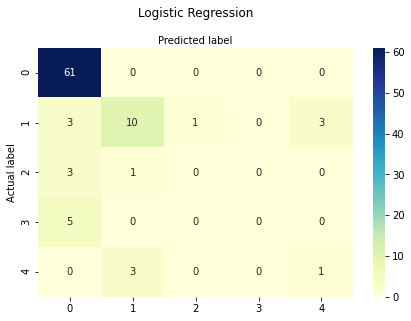

(830, 32) (830,)
(92, 32) (92,)


/home/amin/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


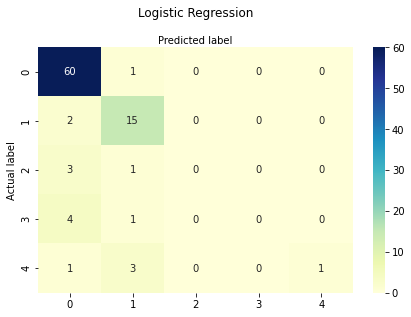

(830, 32) (830,)
(92, 32) (92,)


/home/amin/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


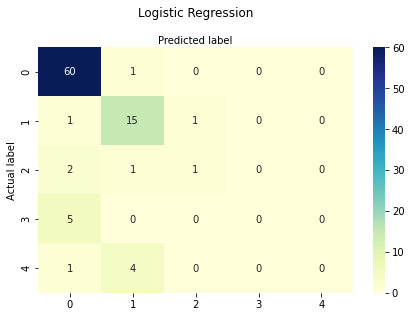

(830, 32) (830,)
(92, 32) (92,)


/home/amin/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


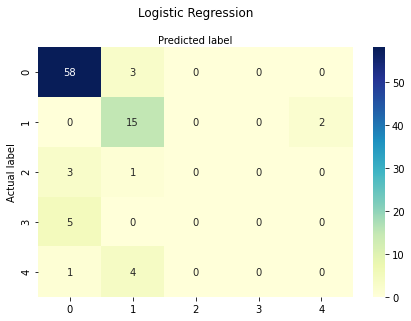

(829, 32) (829,)
(93, 32) (93,)


/home/amin/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


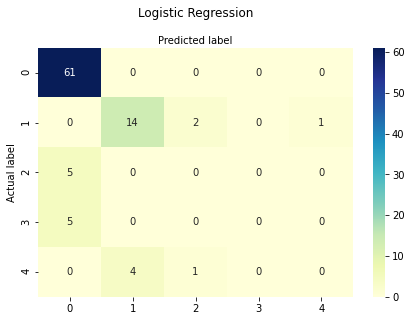

(831, 32) (831,)
(91, 32) (91,)


/home/amin/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


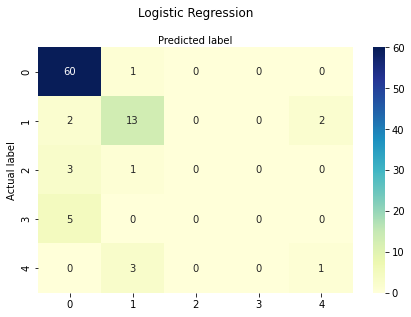

(830, 32) (830,)
(92, 32) (92,)


/home/amin/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


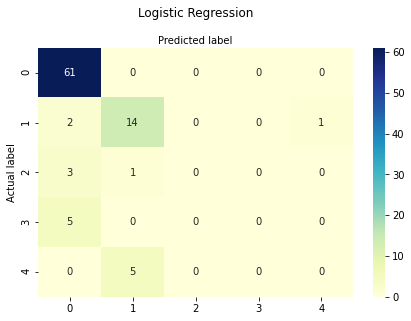

(830, 32) (830,)
(92, 32) (92,)


/home/amin/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


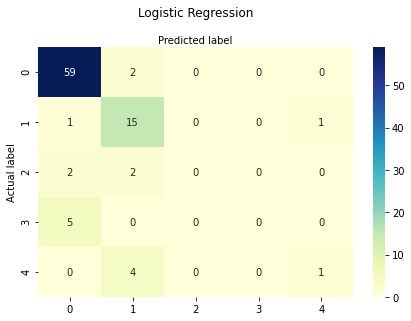

(830, 32) (830,)
(92, 32) (92,)


/home/amin/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


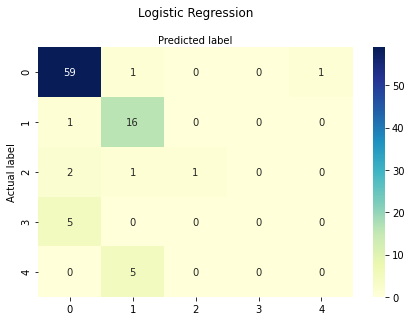

(827, 32) (827,)
(95, 32) (95,)


/home/amin/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


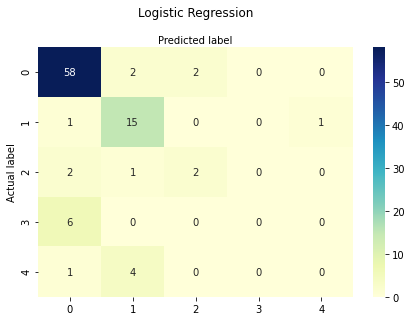

Accuracy:         0.81  -+0.0104
(831, 32) (831,)
(91, 32) (91,)


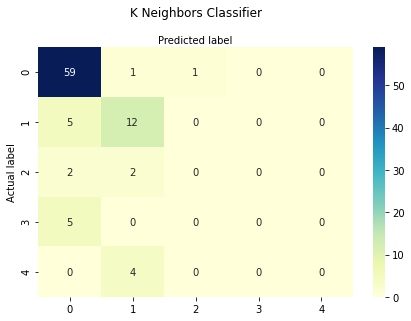

(830, 32) (830,)
(92, 32) (92,)


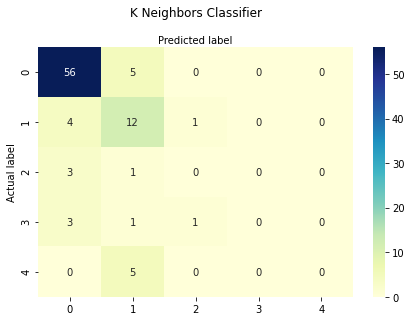

(830, 32) (830,)
(92, 32) (92,)


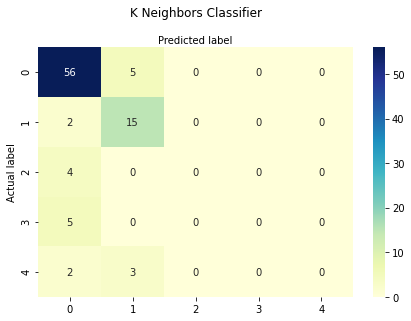

(830, 32) (830,)
(92, 32) (92,)


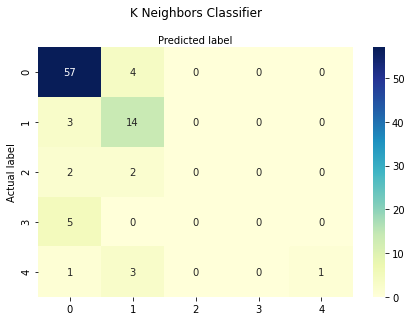

(829, 32) (829,)
(93, 32) (93,)


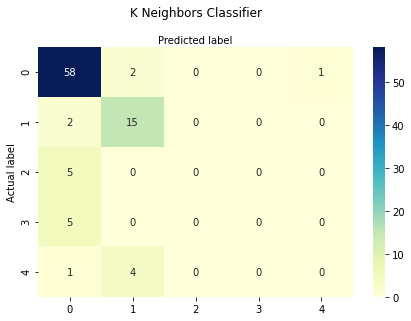

(831, 32) (831,)
(91, 32) (91,)


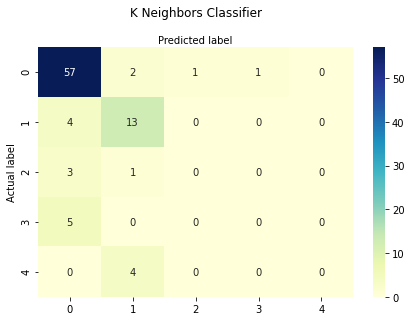

(830, 32) (830,)
(92, 32) (92,)


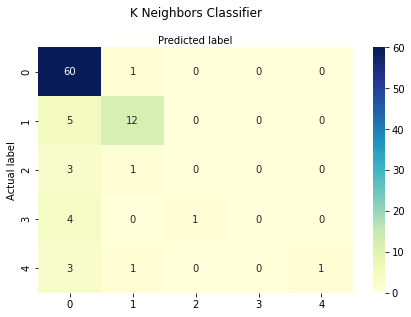

(830, 32) (830,)
(92, 32) (92,)


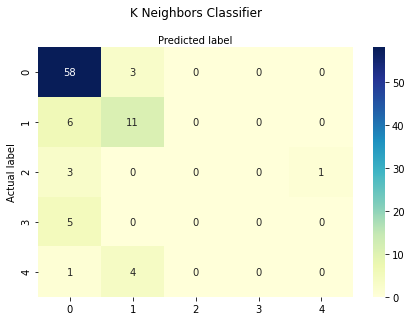

(830, 32) (830,)
(92, 32) (92,)


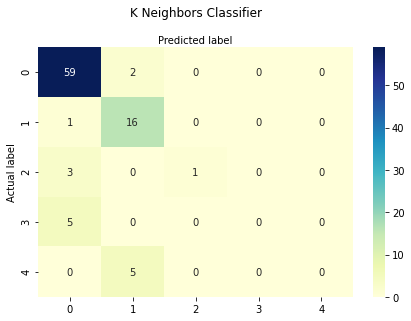

(827, 32) (827,)
(95, 32) (95,)


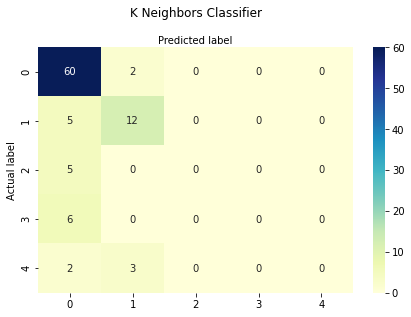

Accuracy:         0.78  -+0.0175
(831, 32) (831,)
(91, 32) (91,)


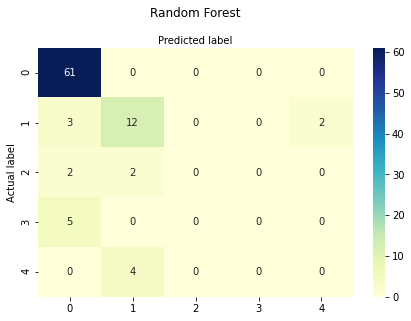

(830, 32) (830,)
(92, 32) (92,)


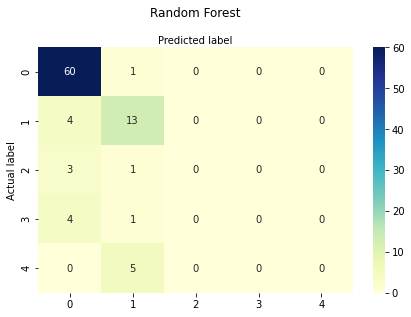

(830, 32) (830,)
(92, 32) (92,)


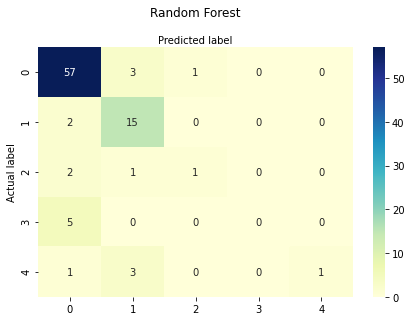

(830, 32) (830,)
(92, 32) (92,)


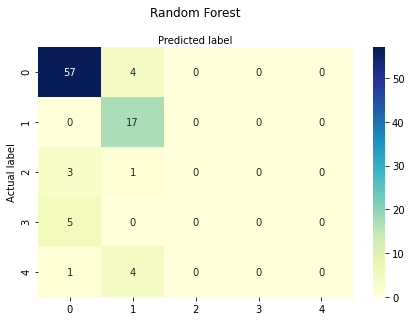

(829, 32) (829,)
(93, 32) (93,)


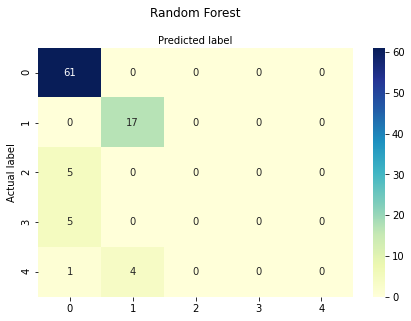

(831, 32) (831,)
(91, 32) (91,)


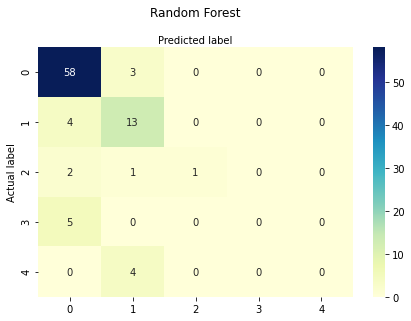

(830, 32) (830,)
(92, 32) (92,)


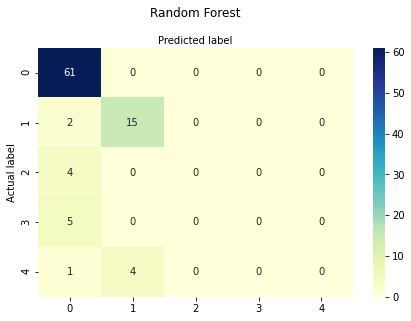

(830, 32) (830,)
(92, 32) (92,)


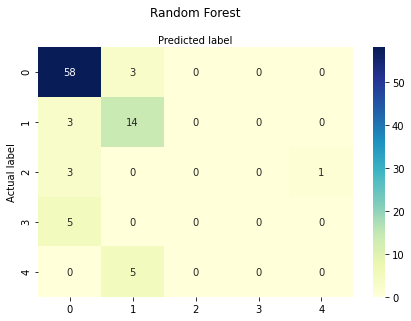

(830, 32) (830,)
(92, 32) (92,)


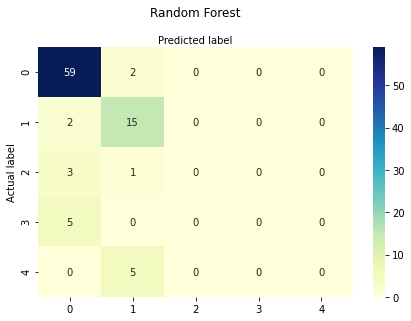

(827, 32) (827,)
(95, 32) (95,)


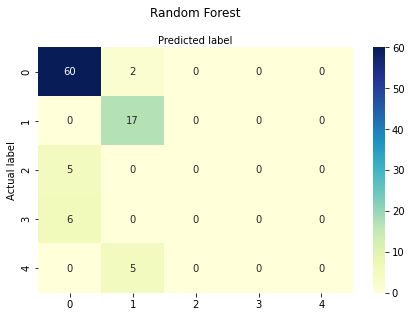

Accuracy:         0.81  -+0.0118
(831, 32) (831,)
(91, 32) (91,)


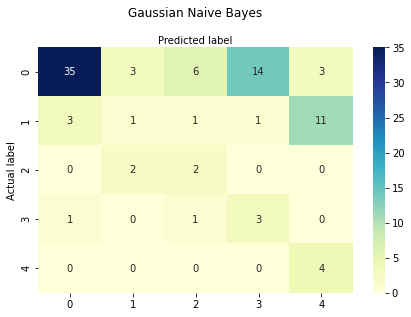

(830, 32) (830,)
(92, 32) (92,)


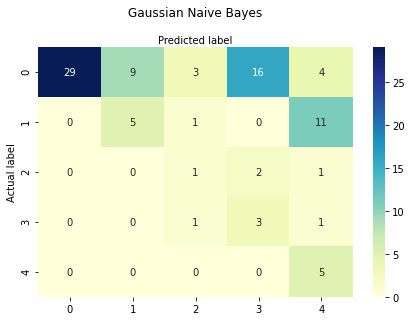

(830, 32) (830,)
(92, 32) (92,)


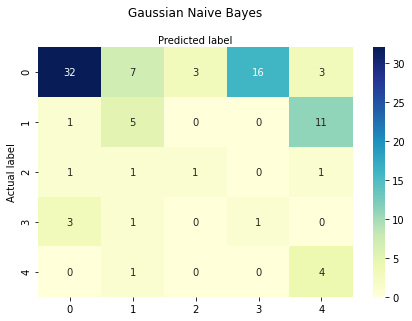

(830, 32) (830,)
(92, 32) (92,)


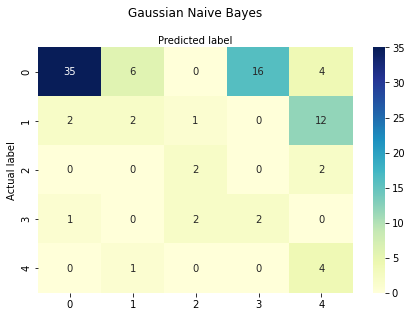

(829, 32) (829,)
(93, 32) (93,)


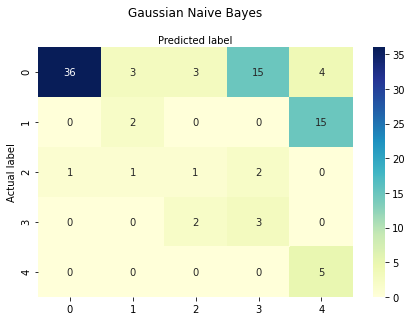

(831, 32) (831,)
(91, 32) (91,)


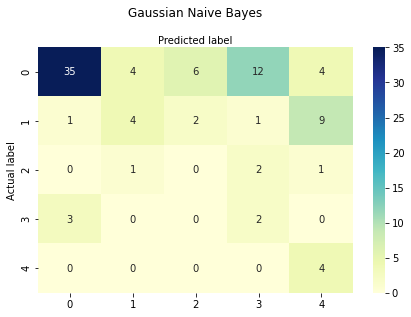

(830, 32) (830,)
(92, 32) (92,)


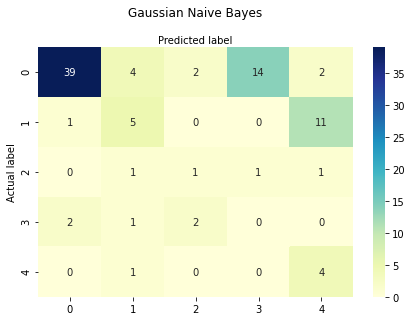

(830, 32) (830,)
(92, 32) (92,)


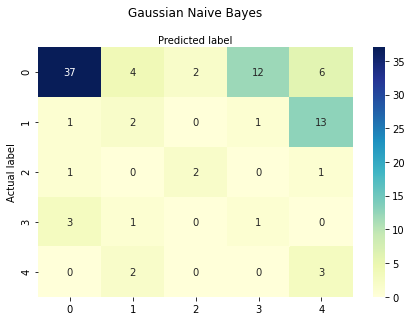

(830, 32) (830,)
(92, 32) (92,)


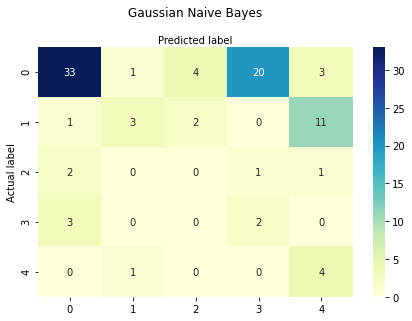

(827, 32) (827,)
(95, 32) (95,)


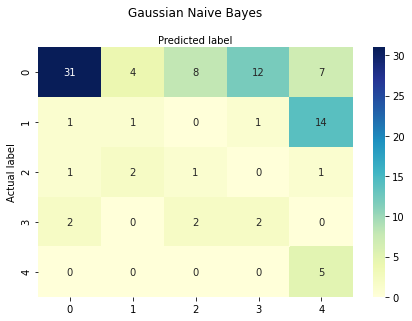

Accuracy:         0.48  -+0.0217
(831, 32) (831,)
(91, 32) (91,)


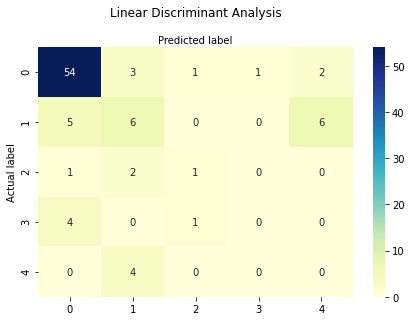

(830, 32) (830,)
(92, 32) (92,)


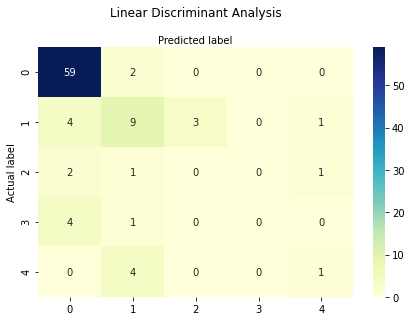

(830, 32) (830,)
(92, 32) (92,)


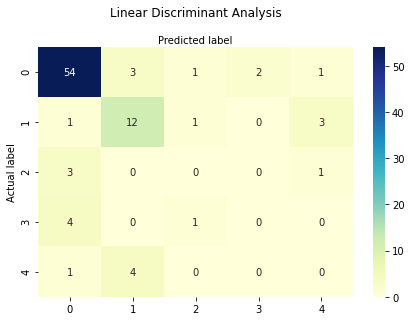

(830, 32) (830,)
(92, 32) (92,)


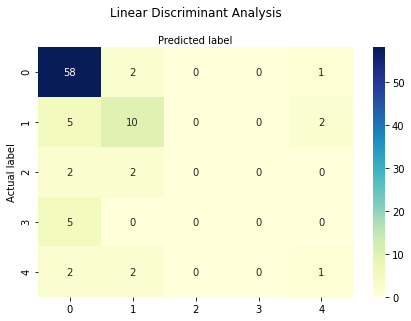

(829, 32) (829,)
(93, 32) (93,)


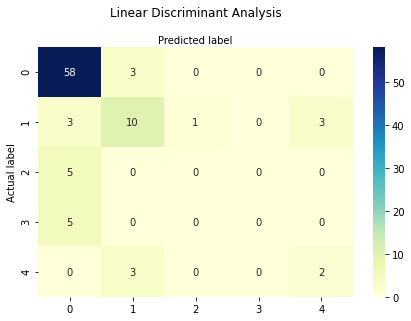

(831, 32) (831,)
(91, 32) (91,)


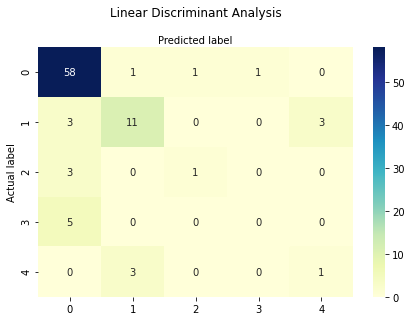

(830, 32) (830,)
(92, 32) (92,)


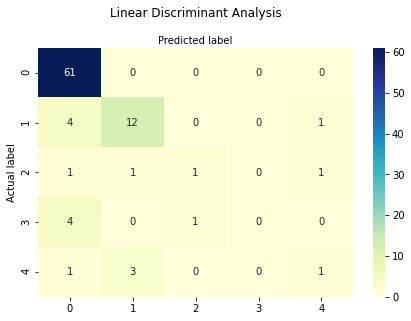

(830, 32) (830,)
(92, 32) (92,)


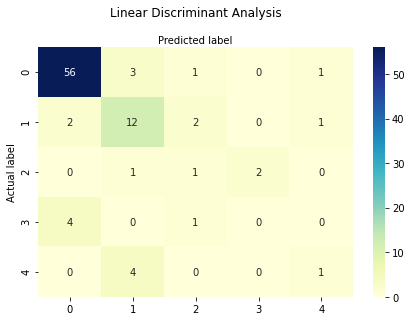

(830, 32) (830,)
(92, 32) (92,)


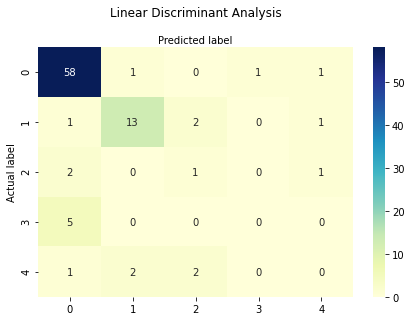

(827, 32) (827,)
(95, 32) (95,)


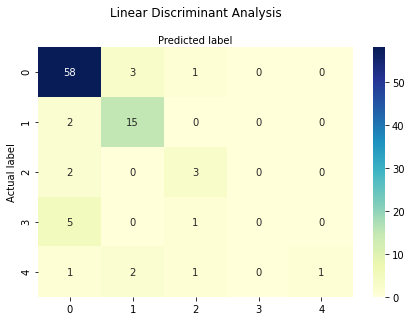

Accuracy:         0.76  -+0.0307
(831, 32) (831,)
(91, 32) (91,)


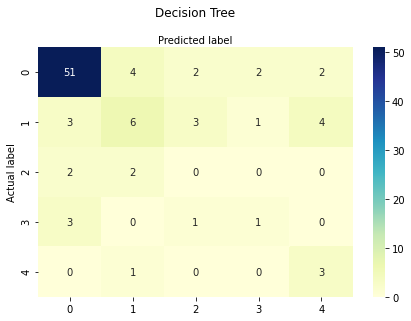

(830, 32) (830,)
(92, 32) (92,)


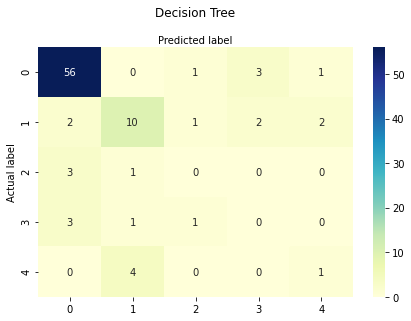

(830, 32) (830,)
(92, 32) (92,)


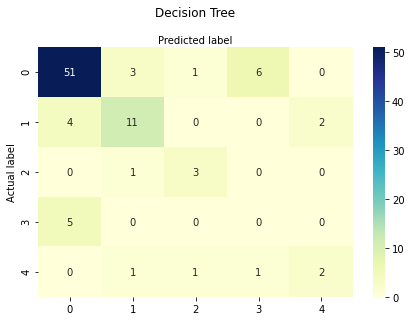

(830, 32) (830,)
(92, 32) (92,)


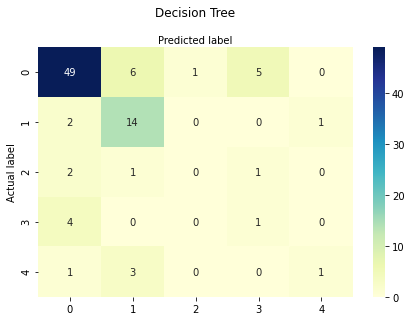

(829, 32) (829,)
(93, 32) (93,)


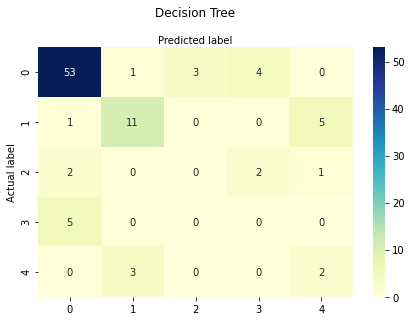

(831, 32) (831,)
(91, 32) (91,)


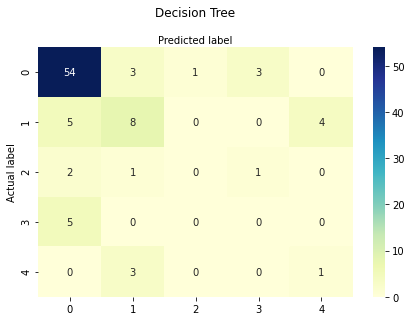

(830, 32) (830,)
(92, 32) (92,)


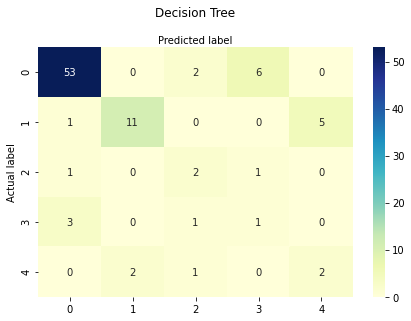

(830, 32) (830,)
(92, 32) (92,)


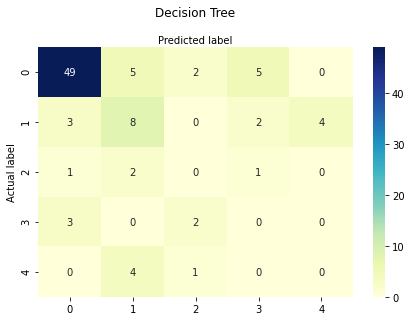

(830, 32) (830,)
(92, 32) (92,)


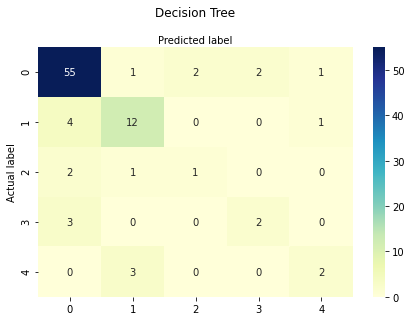

(827, 32) (827,)
(95, 32) (95,)


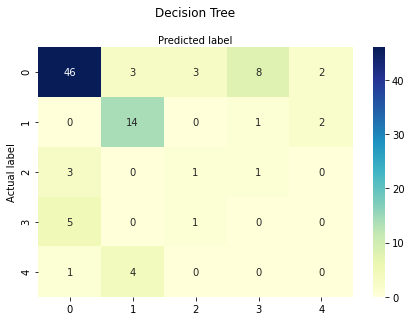

Accuracy:         0.7  -+0.0352
(831, 32) (831,)
(91, 32) (91,)


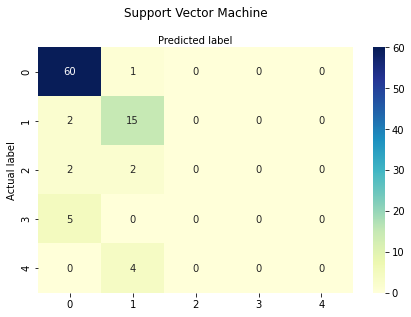

(830, 32) (830,)
(92, 32) (92,)


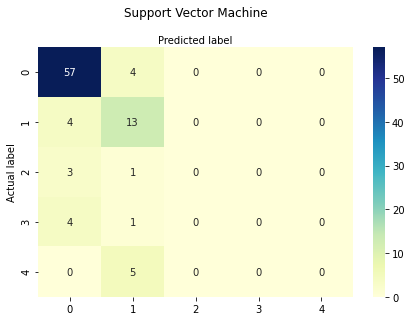

(830, 32) (830,)
(92, 32) (92,)


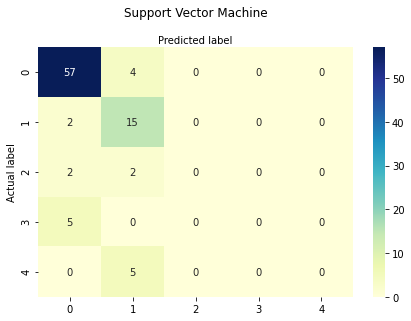

(830, 32) (830,)
(92, 32) (92,)


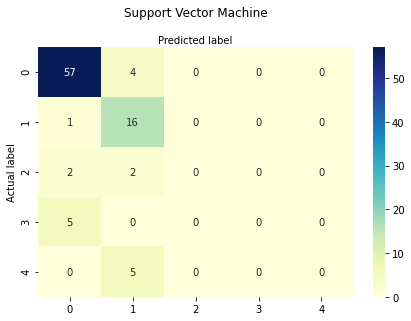

(829, 32) (829,)
(93, 32) (93,)


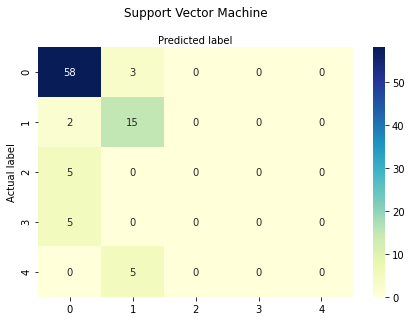

(831, 32) (831,)
(91, 32) (91,)


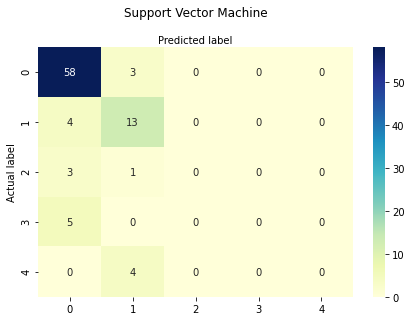

(830, 32) (830,)
(92, 32) (92,)


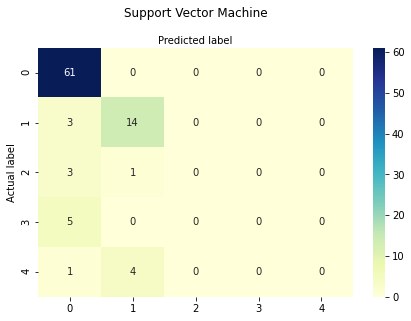

(830, 32) (830,)
(92, 32) (92,)


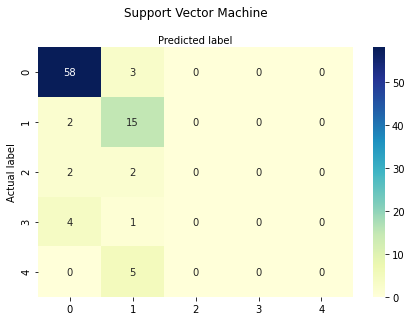

(830, 32) (830,)
(92, 32) (92,)


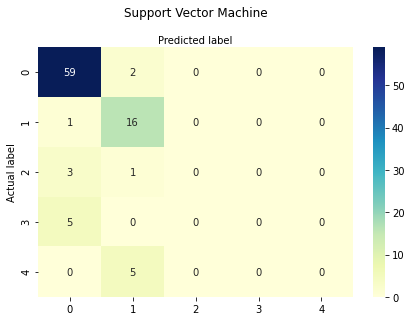

(827, 32) (827,)
(95, 32) (95,)


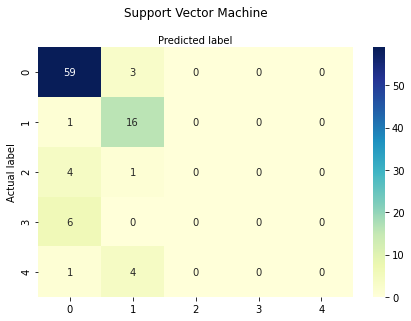

Accuracy:         0.79  -+0.0138
(831, 32) (831,)
(91, 32) (91,)


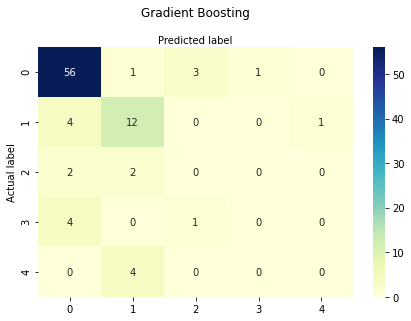

(830, 32) (830,)
(92, 32) (92,)


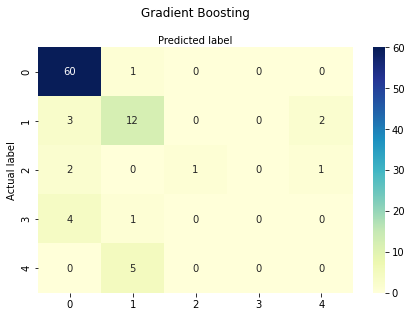

(830, 32) (830,)
(92, 32) (92,)


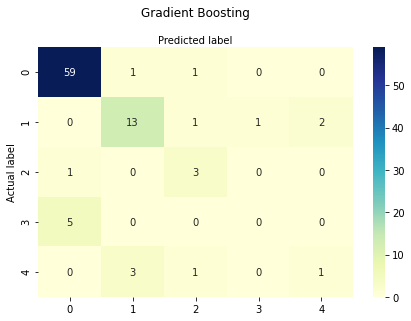

(830, 32) (830,)
(92, 32) (92,)


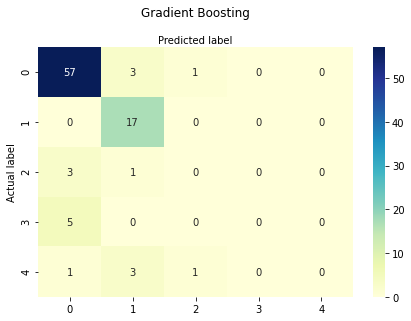

(829, 32) (829,)
(93, 32) (93,)


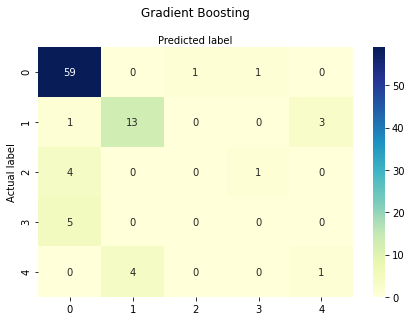

(831, 32) (831,)
(91, 32) (91,)


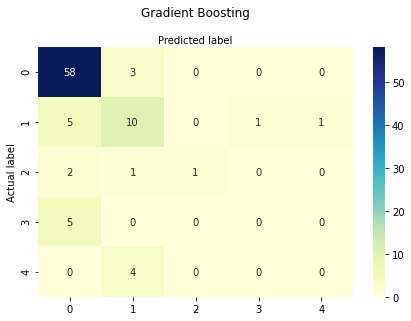

(830, 32) (830,)
(92, 32) (92,)


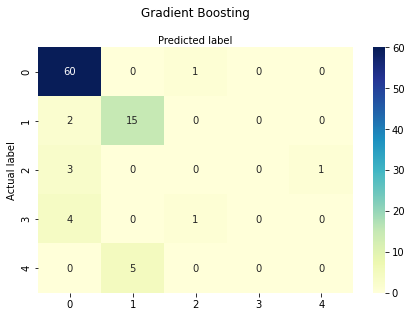

(830, 32) (830,)
(92, 32) (92,)


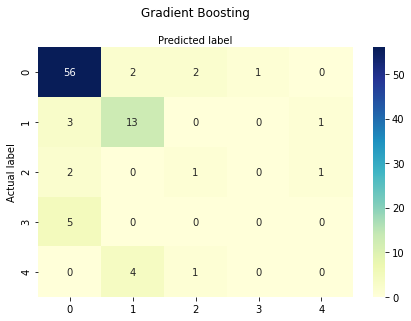

(830, 32) (830,)
(92, 32) (92,)


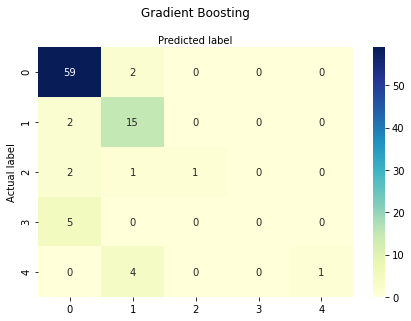

(827, 32) (827,)
(95, 32) (95,)


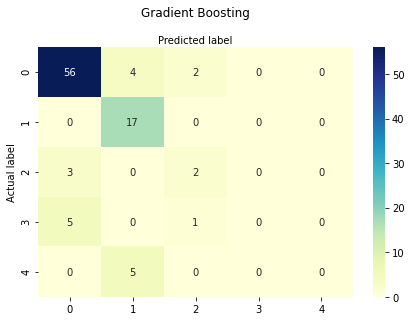

Accuracy:         0.79  -+0.0202
(831, 32) (831,)
(91, 32) (91,)


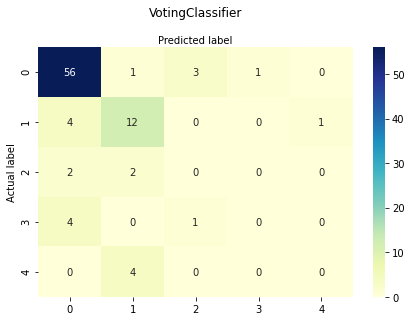

(830, 32) (830,)
(92, 32) (92,)


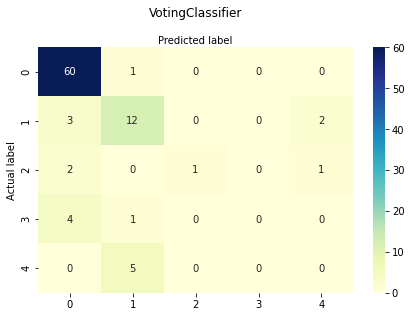

(830, 32) (830,)
(92, 32) (92,)


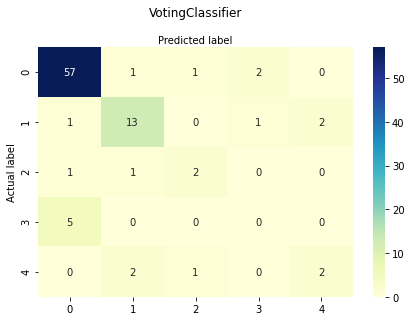

(830, 32) (830,)
(92, 32) (92,)


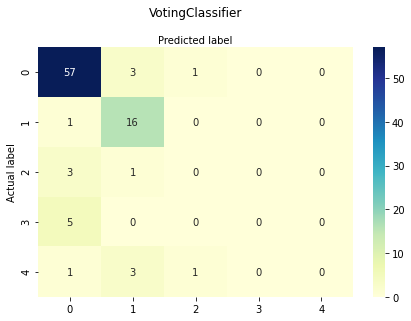

(829, 32) (829,)
(93, 32) (93,)


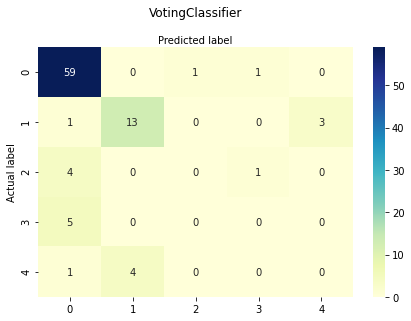

(831, 32) (831,)
(91, 32) (91,)


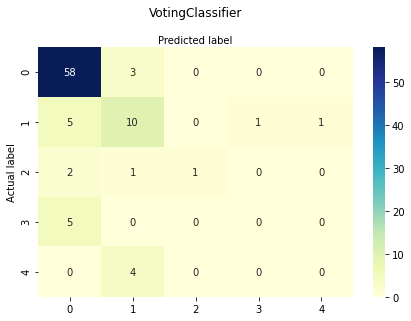

(830, 32) (830,)
(92, 32) (92,)


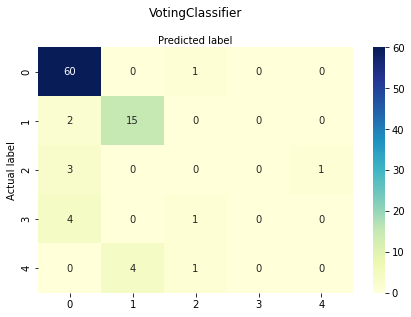

(830, 32) (830,)
(92, 32) (92,)


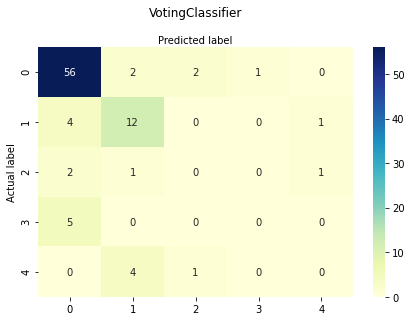

(830, 32) (830,)
(92, 32) (92,)


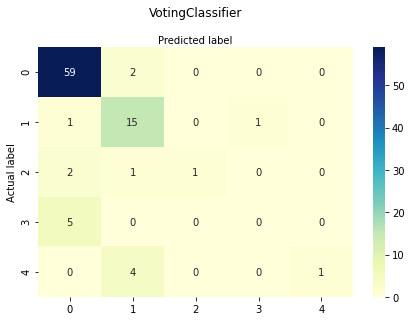

(827, 32) (827,)
(95, 32) (95,)


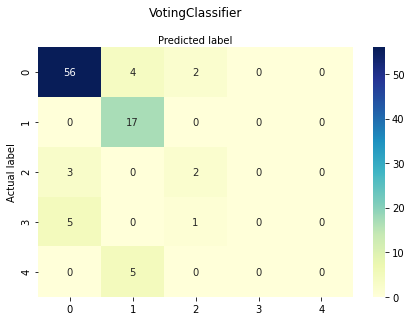

Accuracy:         0.78  -+0.0206


In [31]:
for method in methods:
    if method == 'Logistic Regression':
        CL = LogisticRegression()
    if method == 'K Neighbors Classifier':
        CL = KNeighborsClassifier(n_neighbors=10)
    if method == 'Random Forest':
        CL = RandomForestClassifier(max_depth=35)
    if method == 'Gaussian Naive Bayes':
        CL = GaussianNB()
    if method == 'Linear Discriminant Analysis':
        CL = LinearDiscriminantAnalysis()
    if method == 'Decision Tree':
        CL = DecisionTreeClassifier()
    if method == 'Support Vector Machine':
        CL = SVC()
    if method == 'Gradient Boosting':
        CL = GradientBoostingClassifier()
    if method == 'VotingClassifier':
        cl1 = LogisticRegression()
        cl2 = KNeighborsClassifier(n_neighbors=10)
        cl3 = RandomForestClassifier(max_depth=35)
        cl4 = GaussianNB()
        cl5 = LinearDiscriminantAnalysis()
        cl6 = DecisionTreeClassifier()
        cl7 = SVC()
        cl8 = GradientBoostingClassifier()
        estimator = [(method[0],cl1), (method[1],cl2), (method[2],cl3), (method[3],cl4),\
                     (method[4],cl5), (method[5],cl6), (method[6],cl7), (method[7],cl8)]
        eclf = VotingClassifier(estimators=estimator,
        voting='soft', weights=[10, 8, 10, 1, 8, 5, 8, 10])

    accList = []
    for j in range(10):

        i = j*.1
        k = (j+1)*.1
        #train
        X_train = cat0.iloc[int(k * lenCat0):,:-1].append(\
                  cat1.iloc[int(k * lenCat1):,:-1].append(\
                  cat2.iloc[int(k * lenCat2):,:-1].append(\
                  cat5.iloc[int(k * lenCat5):,:-1].append(\
                  cat6.iloc[int(k * lenCat6):,:-1].append(\
                  cat0.iloc[:int(i * lenCat0),:-1].append(\
                  cat1.iloc[:int(i * lenCat1),:-1].append(\
                  cat2.iloc[:int(i * lenCat2),:-1].append(\
                  cat5.iloc[:int(i * lenCat5),:-1].append(\
                  cat6.iloc[:int(i * lenCat6),:-1]                                       
                                                         )))))))))

        y_train = cat0.iloc[int(k * lenCat0):,-1].append(\
                  cat1.iloc[int(k * lenCat1):,-1].append(\
                  cat2.iloc[int(k * lenCat2):,-1].append(\
                  cat5.iloc[int(k * lenCat5):,-1].append(\
                  cat6.iloc[int(k * lenCat6):,-1].append(\
                  cat0.iloc[:int(i * lenCat0),-1].append(\
                  cat1.iloc[:int(i * lenCat1),-1].append(\
                  cat2.iloc[:int(i * lenCat2),-1].append(\
                  cat5.iloc[:int(i * lenCat5),-1].append(\
                  cat6.iloc[:int(i * lenCat6),-1]                                         
                                                        )))))))))
        print(X_train.shape, y_train.shape)

        #test
        X_test = cat0.iloc[int(i * lenCat0):int(k * lenCat0),:-1].append(\
                 cat1.iloc[int(i * lenCat1):int(k * lenCat1),:-1].append(\
                 cat2.iloc[int(i * lenCat2):int(k * lenCat2),:-1].append(\
                 cat5.iloc[int(i * lenCat5):int(k * lenCat5),:-1].append(\
                 cat6.iloc[int(i * lenCat6):int(k * lenCat6),:-1]))))

        y_test = cat0.iloc[int(i * lenCat0):int(k * lenCat0),-1].append(\
                 cat1.iloc[int(i * lenCat1):int(k * lenCat1),-1].append(\
                 cat2.iloc[int(i * lenCat2):int(k * lenCat2),-1].append(\
                 cat5.iloc[int(i * lenCat5):int(k * lenCat5),-1].append(\
                 cat6.iloc[int(i * lenCat6):int(k * lenCat6),-1]))))
        print(X_test.shape, y_test.shape)
        #preprocessing
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train_transformed = scaler.transform(X_train)
        X_test_transformed = scaler.transform(X_test)
        
        model = CL.fit(X_train, np.array(list(y_train)))
        
        predict = np.array(model.predict(X_test))
        
        cnf_matrix = metrics.confusion_matrix(y_test, predict)

        #matplotlib inline
        class_names=[0,1] # name  of classes
        fig, ax = plt.subplots()
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)

        # create heatmap
        sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
        ax.xaxis.set_label_position("top")
        plt.tight_layout()
        plt.title(method+ ' fold of '+str(j), y=1.1)

        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')

        plt.show()


        acc = metrics.accuracy_score(y_test.values, predict)
        accList.append(acc)


    methodList.append(method)
    confidence = 0.95

    naccList = len(accList)
    maccList = np.mean(accList)
    std_erraccList = sem(accList)
    haccList = std_erraccList * t.ppf((1 + confidence) / 2, naccList - 1)




    print("Accuracy:         "+ str(round(maccList,2)) + '  -+' + str(round(haccList,4)))
    accRes.append(round(maccList,2))
    accConf.append(round(haccList,4))


In [27]:
result = []
result = pd.DataFrame(result)
result['Method'],result['Accuracy'],result['ACC CI'] = methodList,accRes,accConf
result.to_excel('kidney_Classification_Result.xlsx',index=False)
result

,Method,Accuracy,ACC CI
0,Logistic Regression,0.81,0.0104
1,K Neighbors Classifier,0.78,0.0175
2,Random Forest,0.80,0.0114
3,Gaussian Naive Bayes,0.48,0.0217
4,Linear Discriminant Analysis,0.76,0.0307
5,Decision Tree,0.70,0.0366
6,Support Vector Machine,0.79,0.0138
7,Gradient Boosting,0.79,0.0166
8,VotingClassifier,0.78,0.0223


In [11]:

# methodList.append('Logistic Regression')
# confidence = 0.95
# # data = [1, 2, 3, 4, 5]

# naccList = len(accList)
# maccList = np.mean(accList)
# std_erraccList = sem(accList)
# haccList = std_erraccList * t.ppf((1 + confidence) / 2, naccList - 1)




# print("Accuracy:         "+ str(round(maccList,2)) + '  -+' + str(round(haccList,4)))
# accRes.append(round(maccList,2))
# accConf.append(round(haccList,4))

Accuracy:         0.79  -+0.0184


In [12]:
# loologreg = LogisticRegression()
# loologregModel =loologreg.fit(X_train, np.array(list(y_train)))
# predict = np.array(loologreg.predict(X_test))
# cnf_matrix = metrics.confusion_matrix(y_test, predict)

# print(cnf_matrix)

# acc = metrics.accuracy_score(y_test.values, predict)
# print("Logistic Regression Accuracy by LOOCV", acc)

[[60  2  0  0  0]
 [ 1 14  0  0  2]
 [ 3  1  1  0  0]
 [ 6  0  0  0  0]
 [ 0  4  0  0  1]]
Logistic Regression Accuracy by LOOCV 0.8


/home/amin/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


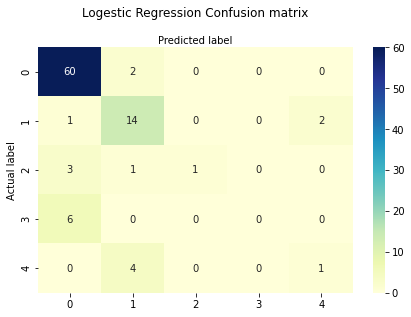

In [13]:
# #matplotlib inline
# class_names=[0,1] # name  of classes
# fig, ax = plt.subplots()
# tick_marks = np.arange(len(class_names))
# plt.xticks(tick_marks, class_names)
# plt.yticks(tick_marks, class_names)

# # create heatmap
# sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
# ax.xaxis.set_label_position("top")
# plt.tight_layout()
# plt.title('Logestic Regression Confusion matrix', y=1.1)

# plt.ylabel('Actual label')
# plt.xlabel('Predicted label')

# plt.show()


In [16]:
# j = 1
# i = j*.1
# k = (j+1)*.1
# #train
# X_train = cat0.iloc[int(k * lenCat0):,:-1].append(\
#           cat1.iloc[int(k * lenCat1):,:-1].append(\
#           cat2.iloc[int(k * lenCat2):,:-1].append(\
#           cat5.iloc[int(k * lenCat5):,:-1].append(\
#           cat6.iloc[int(k * lenCat6):,:-1].append(\
#           cat0.iloc[:int(i * lenCat0),:-1].append(\
#           cat1.iloc[:int(i * lenCat1),:-1].append(\
#           cat2.iloc[:int(i * lenCat2),:-1].append(\
#           cat5.iloc[:int(i * lenCat5),:-1].append(\
#           cat6.iloc[:int(i * lenCat6),:-1]                                       
#                                                  )))))))))

# y_train = cat0.iloc[int(k * lenCat0):,-1].append(\
#           cat1.iloc[int(k * lenCat1):,-1].append(\
#           cat2.iloc[int(k * lenCat2):,-1].append(\
#           cat5.iloc[int(k * lenCat5):,-1].append(\
#           cat6.iloc[int(k * lenCat6):,-1].append(\
#           cat0.iloc[:int(i * lenCat0),-1].append(\
#           cat1.iloc[:int(i * lenCat1),-1].append(\
#           cat2.iloc[:int(i * lenCat2),-1].append(\
#           cat5.iloc[:int(i * lenCat5),-1].append(\
#           cat6.iloc[:int(i * lenCat6),-1]                                         
#                                                 )))))))))
# print(X_train.shape, y_train.shape)

# #test
# X_test = cat0.iloc[int(i * lenCat0):int(k * lenCat0),:-1].append(\
#          cat1.iloc[int(i * lenCat1):int(k * lenCat1),:-1].append(\
#          cat2.iloc[int(i * lenCat2):int(k * lenCat2),:-1].append(\
#          cat5.iloc[int(i * lenCat5):int(k * lenCat5),:-1].append(\
#          cat6.iloc[int(i * lenCat6):int(k * lenCat6),:-1]))))

# y_test = cat0.iloc[int(i * lenCat0):int(k * lenCat0),-1].append(\
#          cat1.iloc[int(i * lenCat1):int(k * lenCat1),-1].append(\
#          cat2.iloc[int(i * lenCat2):int(k * lenCat2),-1].append(\
#          cat5.iloc[int(i * lenCat5):int(k * lenCat5),-1].append(\
#          cat6.iloc[int(i * lenCat6):int(k * lenCat6),-1]))))

(830, 32) (830,)


In [28]:
# from sklearn import datasets
# from sklearn.model_selection import cross_val_score
# from sklearn.linear_model import LogisticRegression
# from sklearn.naive_bayes import GaussianNB
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import VotingClassifier

# # iris = datasets.load_iris()
# # X, y = iris.data[:, 1:3], iris.target

# clf1 = LogisticRegression(random_state=1)
# clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
# clf3 = GaussianNB()

# eclf = VotingClassifier(
#     estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)],
#     voting='soft', weights=[3, 3, 1])

# for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):
#     scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10)
#     print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))